Loading Data and Libraries

In [1]:
import pickle
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA
from collections import *
from scipy.signal import butter, filtfilt
from collections import Counter
import seaborn as sns
import scipy.signal as signal
from scipy.spatial.distance import cityblock
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.backends.backend_pdf
import math

file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_breath1.obj", "rb")
trials_breath = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\static_data.obj", "rb")
static_data = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_raw1.obj", "rb")
trials_raw = pickle.load(file)
metadata = pd.read_csv(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\d2k project metadata.csv")

Data Pre-Processing Functions

In [2]:
def butter_bandpass(lowcutoff, highcutoff, fs, order):
    """
    This function takes in the filter parameters and
    does the simple calculations needed to account for the
    Nyquist frequency and using the scipy butter function
    to produce the numerator and polynomials of the IIR filter \n
    Inputs: \n
    1) lowcutoff - lower frequecy cutoff of bandpass filter
    2) highcutoff - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order \n
    Outputs: \n
    1) a - denominator polynomials of the IIR filter
    2) b - numerator polynomials of the IIR filter

    """
    nyq = 0.5 * fs  #nyquist frequency
    lowcutoff = lowcutoff / nyq        
    highcutoff = highcutoff / nyq
    a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
    return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order):
    """
    This function wraps the scipy functions needed to implement a 
    bandpass fillter and ultimately filters the signal \n
    Inputs: \n
    1) data - signal to be filtered
    2) lowcutoff - lower frequecy cutoff of bandpass filter
    3) highcutoff - upper frequecy cutoff of bandpass filter
    4) fs - sampling frequency
    5) order - filter order \n
    Outputs: \n
    1) filtered_signal

    """
    a,b = butter_bandpass(lowcutoff, highcutoff, fs, order=order)
    filtered_signal = filtfilt(a,b, data)
    return filtered_signal

def bandpass_filter(low, high, fs,order, signal, quiet = False):
    """
    This function bandpasses filters a given signal and has an option
    of plotting what the signal looks like before and after filtering \n
    Inputs: \n
    1) low - lower frequecy cutoff of bandpass filter
    2) high - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order 
    5) signal - signal to be filtered
    6) quiet - (default: False) boolean indicating whether or not to display signal before and after filtering \n
    Outputs: \n
    1) filtered_data

    """
    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    if quiet == False:    
        plt.figure(figsize = (8,8))
        plt.plot(signal, label='Raw signal')
        plt.title("Unfiltered signal", size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

        plt.figure(figsize = (8,8))
        plt.plot(filtered_data)
        plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
        plt.xlabel("Time (ms)", size = 10)
        plt.ylabel("Ventflow", size = 10)

    return filtered_data

def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = [list of timestamps] \n
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset] \n
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a 
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None, otherlabel2 = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not. Set to False if other_label is phase onset \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}
    
    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), all=False, phase=otherlabel, phase2=otherlabel2)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1])
            other_phase_timestamps = []
            if trial_onset_first:
                for trial in range(1,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)
            else:
                for trial in range(2,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]
        
            #find current interval and include it in phase_interval_per_mouse
            if (start_index < len(raw_data[str(mouse)]["raw"][str(data_type)])) & (end_index < len(raw_data[str(mouse)]["raw"][str(data_type)])):
                current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
                phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                raise ValueError("{}, {}, mouse:{}, start: {}, end: {}, total length: {}" .format(other_phase_timestamps, phase_onset_timestamps, mouse, start_index, end_index, 
                                                                                            len(raw_data[str(mouse)]["raw"][str(data_type)])))

            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


Comparing Different Breath Detection Methods

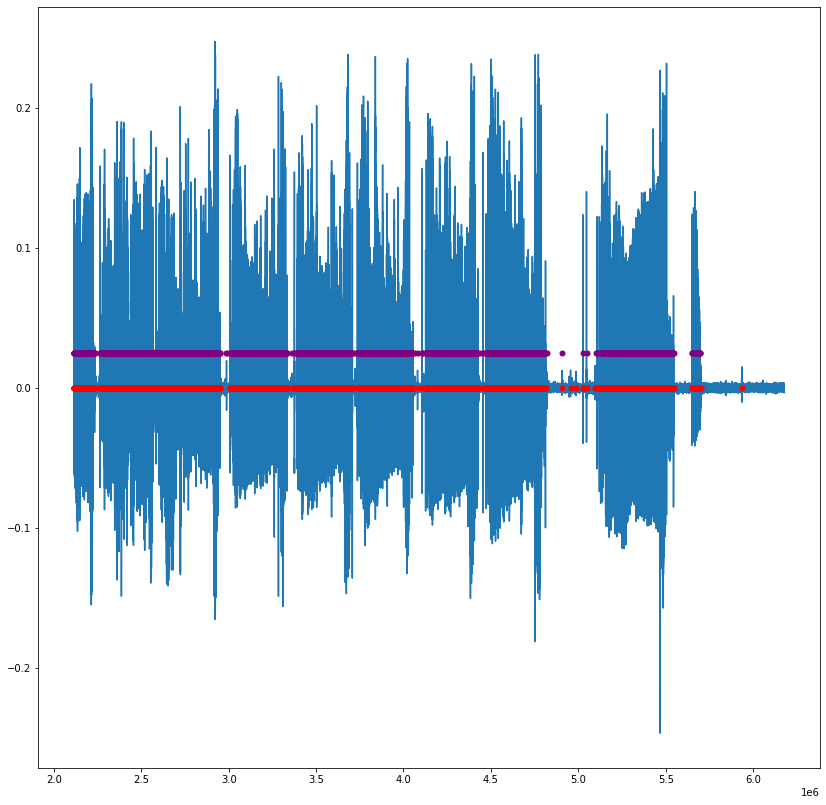

In [3]:
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

mouse = "M20868"
start = 4250000
end = start + 1000000

data = trials_raw[mouse]["raw"][trials_raw[mouse]["raw"]["trial_no"] >= 0]

if "index" in data.columns:
    time = np.array(data["index"])
else:  
    time = data.index

breathlists = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > time[0]) & (trials_breath[mouse]["breath"]["Breath Number"] < time[-1])]

y = bandpass_filter(1,15,1000,2,data["Breathing_flow_signal"], quiet = True)

plt.figure(figsize=(14,14))
plt.plot(time,y)

y = cumtrapz(y, x=time)

peaks1, _ = find_peaks(-y, distance = 200, prominence = 1.05)

x = np.arange(0,np.shape(y)[0])
sortId = np.argsort(x)
x = x[sortId]
y = y[sortId]

plt.plot(peaks1+time[0], np.zeros(len(peaks1)), ".", c = "red", markersize=10)
plt.plot(breathlists["Timestamp_Inspiration"]*1000,np.zeros(len(breathlists["Timestamp_Inspiration"])) + 0.025, ".", c = "purple", markersize=10)
plt.show()

Determining Calibration Normalization Factor by Mouse

In [4]:
#calibration

for mouse in trials_raw.keys():
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    start = calibr[-1] * 1e3
    end = start + 4e4
    calibration_volume = 20
    trials_breath[mouse]["breath"]["bpm"] = 60 / trials_breath[mouse]["breath"]["Inspiratory_Duration"]
    data_subset = trials_breath[mouse]["breath"][(trials_breath[mouse]["breath"]["Breath Number"] > start) & (trials_breath[mouse]["breath"]["Breath Number"] < end) & ((trials_breath[mouse]["breath"]["bpm"] > 60))]
    number_breath = len(data_subset)
    avg_tidal = np.mean(data_subset["Tidal_Volume_uncorrected"])
    if mouse in ["M21267","M21269","M20868"]:
        print("Mouse {} avg_tide value: {} Number of breaths: {} ***" .format(mouse,avg_tidal, number_breath))
    else:
        print("Mouse {} avg_tide value: {} Number of breaths: {}" .format(mouse,avg_tidal, number_breath))



Mouse M20864 avg_tide value: 5.450345404434838 Number of breaths: 37
Mouse M20865 avg_tide value: 5.6155805340859635 Number of breaths: 28
Mouse M20867 avg_tide value: 5.7730280803842735 Number of breaths: 34
Mouse M20868 avg_tide value: 1.2273356579363026 Number of breaths: 19 ***
Mouse M20869 avg_tide value: 5.589587258294835 Number of breaths: 28
Mouse M20870 avg_tide value: 5.413530352640375 Number of breaths: 37
Mouse M20874 avg_tide value: 5.457388311802665 Number of breaths: 30
Mouse M21480 avg_tide value: 6.383475394382491 Number of breaths: 26
Mouse M21481 avg_tide value: 6.984162404390876 Number of breaths: 22
Mouse M21483 avg_tide value: 6.830466769471838 Number of breaths: 24
Mouse M21484 avg_tide value: 7.549759481145848 Number of breaths: 21
Mouse M21486 avg_tide value: 8.037494088944518 Number of breaths: 19
Mouse M21487 avg_tide value: 6.400750076101986 Number of breaths: 27
Mouse M21488 avg_tide value: 6.783784835605594 Number of breaths: 23
Mouse M21264 avg_tide value

Breath Extraction Functions

In [3]:
def trial_number(metadata, custom_breathlists, breath_start, mouse):
    """
    Given the custom breathlists dictionary mapping mouse IDs to their 
    corresponding custom breathlists, this function adds a column to that dataframe
    indicating the trial number in which each breath took place \n

    Inputs: \n
    1) metadata
    2) custom_breathlists - dictionary mapping each mouse ID to its corresponding custom breathlists
    3) breath_start - dataframe column indicating timestamps of inspiration
    4) mouse - mouse ID
    """

    #retreiving timestamps of each trials
    all_timestamps = compute_timestamps(metadata, mouse, all=True)

    #assigning trial number 0 to all breaths before onset of trial 1
    custom_breathlists[mouse].loc[breath_start < all_timestamps["trial"][0]*1000, "Trial Number"] = 0

    #assigning the last trial number to the breaths that happened in the last breath
    custom_breathlists[mouse].loc[breath_start > all_timestamps["trial"][-1]*1000, "Trial Number"] = len(all_timestamps["trial"])

    #assigning the rest of the trial numbers
    for timestamp in range(1,len(all_timestamps["trial"])):
        custom_breathlists[mouse].loc[(breath_start < all_timestamps["trial"][timestamp]*1000) & (breath_start > all_timestamps["trial"][timestamp-1]*1000), "Trial Number"] = timestamp

phase2number = {"Cal 20 Room Air": 0,
                "Pre-CNO Room Air": 1,
                "Pre-CNo Room Air": 1,
                "Post-CNO Room Air": 2,
                "Post-CNo Room Air": 2,
                "trial onset" : 3,
                "apea starts" : 4,
                "apnea starts" : 4,
                "first gasp" : 5,
                "eupnea starts" :6,
                "eupnea recovery" : 6,
                "Cal 5 Room Air": 7
                }

number2phase = {0 : "Cal 20 Room Air",
                1 : "Pre-CNO Room Air",
                2 : "Post-CNO Room Air",
                3 : "Trial Onset",
                4 : "Apnea Starts",
                5 : "First Gasp",
                6 : "Eupnea Recovery",
                7 : "Cal 5 Room Air"
                }

def phase_type(metadata, custom_breathlists, breath_start, mouse, phase2number, number2phase):
    """
    Given the custom breathlists dictionary mapping mouse IDs to their 
    corresponding custom breathlists, this function adds a column to that dataframe
    indicating the phase in which each breath took place and another column indicating an
    arbitraty code number corresponding to that phase \n

    Inputs: \n
    1) metadata
    2) custom_breathlists - dictionary mapping each mouse ID to its corresponding custom breathlists
    3) breath_start - dataframe column indicating timestamps of inspiration
    4) mouse - mouse ID
    5) phase2number - arbitrary mapping of phase name to an arbitrarily chosen integer
    6) number2phase - inverese of phase2number
    """

    #retrieving all timestamps in the experiment
    all_timestamps = compute_timestamps(metadata, mouse, all=True, breath_only = True)

    custom_breathlists[mouse].loc[breath_start < all_timestamps["other"]["timestamp"][0]*1000, "Phase Number"] = phase2number[all_timestamps["other"]["comment"][0]]
    custom_breathlists[mouse].loc[breath_start < all_timestamps["other"]["timestamp"][0]*1000, "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][0]]]
    custom_breathlists[mouse].loc[breath_start > all_timestamps["other"]["timestamp"][-1]*1000, "Phase Number"] = phase2number[all_timestamps["other"]["comment"][-1]]
    custom_breathlists[mouse].loc[breath_start > all_timestamps["other"]["timestamp"][-1]*1000, "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][-1]]]
    
    for timestamp in range(1,len(all_timestamps["other"]["timestamp"])):
        
        if all_timestamps["other"]["comment"][timestamp-1].isdecimal():
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Number"] = phase2number["trial onset"]
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Type"] = "Trial Onset"
        else:
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Number"] = phase2number[all_timestamps["other"]["comment"][timestamp-1]]
            custom_breathlists[mouse].loc[(breath_start < all_timestamps["other"]["timestamp"][timestamp]*1000) & (breath_start > all_timestamps["other"]["timestamp"][timestamp-1]*1000), "Phase Type"] = number2phase[phase2number[all_timestamps["other"]["comment"][timestamp-1]]]

def label_breaths(metadata, custom_breathlists, mouse, breath_start, phase2number, number2phase):
    """
    This function adds 3 columns to the custom breathlists dataframe: \n
    1) column with trial number in which each breath took place
    2) column with phase type in which each breath took place
    3) column with number corresponding to a phase type in which each breath took place based on the arbitrary phase2number assignments
    """
    trial_number(metadata, custom_breathlists, breath_start,mouse)

    phase_type(metadata,custom_breathlists, breath_start, mouse, phase2number, number2phase)

def extract_breath(data,start,end, time_zero):
    """
    Given start and end timestamp of a given breath, this function
    extracts and returns the data corresponding to the breath as a
    normalized array
    """
    start = start - time_zero
    end = end - time_zero

    breath = data[start:end]

    return breath - np.mean(breath)


In [4]:
from scipy.integrate import cumtrapz
from scipy.signal import find_peaks
import operator

def clean_breath_data(raw_data, mouse, freqlow, freqhigh, filter_order, sampling_freq):
    """
    This function filters the raw breathing data and fixes an issue present in 3 of the mice \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) freqlow - lower bound for bandpass filter
    4) freqhigh - upper bound for bandpass filter
    5) filter_order - filter order
    6) sampling_freq - sampling frequency \n

    Outputs: \n
    1) data - raw_data dataframe corresponding to "mouse" but refined for use later
    2) filtered_data - array corresponding to breathing data from raw_data after filtering
    """
    
    #remove section of missing data from the only 3 mice with that problem
    timestamps = np.array(raw_data[mouse]["raw"]["Timestamp"])

    #time between each inspiration timestamps
    lengths = timestamps[1:] - timestamps[:-1]

    #excluding parts of breathing data missing readings for longer than a seconds
    if mouse in ["M20868", "M21267", "M21269"]:
        data = raw_data[mouse]["raw"][np.where(lengths>1)[0][0]+1:]
    else:
        data = raw_data[mouse]["raw"]

    #resetting index for consistency of the data with peak indices
    data.reset_index(inplace= True)

    #filtering data
    filtered_data = bandpass_filter(freqlow,freqhigh,sampling_freq,filter_order,data["Breathing_flow_signal"], quiet = True)
    
    return data, filtered_data
    
def find_breath_timestamps(raw_data: dict, mouse: str, filtered_data, peak_prominence : float, p2p_min: float):
    """
    Tthis function returns the index of the first breath indicating when the mouse was first mounted on the rig.
    This function also returns the inspiration timestamps of all the breaths \n

    Inputs: \n
    1) raw_data - 2D dictionary mapping each mouse ID to dataframe corresponding to its raw data
    2) mouse - mouse ID
    3) filtered_data - array corresponding to breathing data from raw_data after filtering
    4) peak_prominence - value indicating how much higher the peaks we're looking for need to be than data around it
    5) p2p_min - minimum distance between two peaks 

    Outputs: \n
    1) mouse_online - timestamp during which mouse was mounted onto rig
    2) breath_timestamps - all inspiration timestamps 
    3) expiration_timestamps - all expiration timestamps
    """

    time = raw_data["index"]

    #finding all the timestamps of onset of inspiration and expiration
    y_volume = cumtrapz(filtered_data, x=time)

    peaks, _ = find_peaks(-y_volume, distance = p2p_min, prominence = peak_prominence)
    peaks = peaks + time[0]
    exp_peaks, _ = find_peaks(y_volume, distance = p2p_min, prominence = peak_prominence)
    exp_peaks = exp_peaks + time[0]
    
    #taking care of inconsistencies in a couple of the data files
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    if mouse not in ["M20868", "M21267", "M21269"]:
        narrowed_peaks = peaks[peaks > (calibr[-1]*1000 + 5e4)]
    else:
        narrowed_peaks = peaks

    #identifying where exactly in
    #the data the mouse is actually mounted onto the machine
    for peak in range(0,len(peaks)):
        distance = narrowed_peaks[peak+40] - narrowed_peaks[peak]
        if distance < 40e3:
            starter_peak = peak
            break
    
    #timestamp where the mouse was mounted on the rig
    mouse_online = raw_data["Timestamp"].iloc[narrowed_peaks[starter_peak]]

    #finding all the breaths detected after mouse mounted on rig
    breath_timestamps = narrowed_peaks[starter_peak:]
    expiration_timestamps = exp_peaks[exp_peaks > breath_timestamps[0]]

    peaks1=breath_timestamps
    peaks0=expiration_timestamps

    #accounting for all instances in which consective expirations were detected with
    #no insipirations inbetween and vice versa
    expiration =  [1] * len(peaks0)
    inspiration =  [-1] * len(peaks1)

    breath_out = list(zip(list(peaks0), expiration))
    breath_in = list(zip(list(peaks1), inspiration))

    all_breaths = breath_out + breath_in
    all_breaths.sort(key=operator.itemgetter(0))

    timestamp_type = list(zip(*all_breaths))
    test = np.array(timestamp_type[1][:-1]) + np.array(timestamp_type[1][1:])

    consecutives = np.where(test != 0)[0]

    for index in consecutives:
        del all_breaths[index+1]
        consecutives -= 1

    all_timestamps = np.array(list(zip(*all_breaths))[0])
    breath_timestamps = all_timestamps[0::2]
    expiration_timestamps = all_timestamps[1::2]

    #if last peak deteced was an inspiration, remove it. Making sure last peak detected was expiration
    if len(breath_timestamps) > len(expiration_timestamps):
        breath_timestamps = breath_timestamps[:-1]
        expiration_timestamps = expiration_timestamps[:-1]
    else: #removing last expiration since last inspiration will be discarded later
        expiration_timestamps = expiration_timestamps[:-1]

    return mouse_online, breath_timestamps, expiration_timestamps, time[0]

def extract_all_breaths(original_breathlists: dict, custom_breathlists: dict, mouse : str, breath_timestamps, expiration_timestamps, filtered_data, breath_length_cutoff:int, time_zero:int):
    """
    Given an dictionary, breath timestamps, and filtered data 
    this function extracts every single breath and information on each breath in
    a dataframe in the dictionary and maps it to mouse ID as follows:
    custom_breathlists[mouseID] = dataframe with information on all breaths
    """

    #calculating duration of all stamps
    breath_durations = breath_timestamps[1:] - breath_timestamps[:-1]

    setting_up_breath_Df = {"Breath Start Timestamp (ms)":breath_timestamps[:-1], "Expiration Timestamp (ms)":expiration_timestamps,
                            "Breath End Timestamp (ms)":breath_timestamps[1:], "Breath Duration (ms)":breath_durations}
    custom_breathlists[mouse] = pd.DataFrame(data=setting_up_breath_Df)

    #removing breaths 
    custom_breathlists[mouse] = custom_breathlists[mouse][custom_breathlists[mouse]["Breath Duration (ms)"] < breath_length_cutoff]
    custom_breathlists[mouse].reset_index(inplace=True)

    all_breaths = []
    breath_height = []

    #volume correction of raw data
    normalization_factor = find_normalization_factor(original_breathlists, mouse)
    if mouse in ["M21269", "M20868"]:
        filtered_data = filtered_data * 1
    else:
        filtered_data = filtered_data * normalization_factor

    #extracting data corresponding to each breath + calculating height of each breath
    for index, row in custom_breathlists[mouse].iterrows():
        all_breaths.append(extract_breath(filtered_data, row["Breath Start Timestamp (ms)"], row["Breath End Timestamp (ms)"], time_zero))
        breath_height.append(np.max(all_breaths[index]) - np.min(all_breaths[index]))

    custom_breathlists[mouse]["Breath Data"] = all_breaths
    custom_breathlists[mouse]["Breath Height"] = breath_height

    return custom_breathlists

def find_normalization_factor(breathlists, mouse, calibration_volume = 20):
    """
    Given breathlists, mouse, calibration volume, this function computes 
    the normalization factor by which we multiply the instantaneous
    tidal volume readings to normalize them
    """
    
    calibr = compute_timestamps(metadata, mouse, phase = "Cal 20 Room Air")
    start = calibr[-1] * 1e3
    end = start + 4e4
    
    breathlists[mouse]["breath"]["bpm"] = 60 / breathlists[mouse]["breath"]["Inspiratory_Duration"]
    data_subset = breathlists[mouse]["breath"][(breathlists[mouse]["breath"]["Breath Number"] > start) & (breathlists[mouse]["breath"]["Breath Number"] < end) & ((breathlists[mouse]["breath"]["bpm"] > 60))]
    avg_tidal = np.mean(data_subset["Tidal_Volume_uncorrected"])
    
    normalization_factor = calibration_volume/avg_tidal
    
    return normalization_factor

In [5]:
def custom_breathlists_per_mouse(raw_data, original_breathlists, custom_breathlists, mouse, bandpass_lowfreq, bandpass_highfreq, filter_order, sampling_freq, p2p_min, peak_prominence, breath_length_cutoff):
    """
    Wrapper functions given raw data per mouse that creates breathlists as dictionary mapping mouseID to dataframe of breathlists\n

    Inputs: \n
    1) raw_data - 2D dictionary containing dataframe of raw data formatted as as raw_data[mouseID]["raw"]
    2) original_breathlists - breathlists provided by the lab. This is used for volume correction
    3) custom_breathlists - 2D dictionary formatted as custom_breathlists[mouseID] so that we can add breathlists for other mice to it
    4) mouse - mouse ID
    5) bandpass_lowfreq - lower bound for butterworth bandpass filter
    6) bandpass_highfreq - upper bound for butterworth bandpass filter
    7) filter_order - butterworth filter order
    8) smapling_freq - sampling frequency of raw data
    9) p2p_min - minimum distance between peaks of two breaths/ minimum length of breath to detect
    10) peak_prominence - how much higher a peak of a breath should be than its surroundings
    11) breath_length_cutoff - max breath duration to cutout detected breaths that include extended periods where the mouse is not breathing

    Outputs: \n
    1) custom_breathlists - dictionary mapping mouse ID to dataframe containing breathlists
    2) mouse_mount_timestamp - timestamp where mouse is mounted onto rig
    """

    #clean up and filter raw_data
    refined_trials_raw, filtered_data = clean_breath_data(raw_data, mouse, freqlow = bandpass_lowfreq,freqhigh= bandpass_highfreq, filter_order = filter_order, sampling_freq = sampling_freq)
    
    #extract all breath timestamps
    mouse_mount_timestamp, breath_timestamps, expiration_timestamps, time_zero = find_breath_timestamps(refined_trials_raw, mouse, filtered_data,
                                                                        p2p_min=p2p_min,peak_prominence=peak_prominence)

    #extract data for every single breaths (readings for entire breath) and put it in dataframe with the rest of breath information
    custom_breathlists = extract_all_breaths(original_breathlists, custom_breathlists, mouse, breath_timestamps, expiration_timestamps,
                                            filtered_data, breath_length_cutoff, time_zero)

    #label breaths based on which trial/ phase they are in
    label_breaths(metadata,custom_breathlists, mouse, custom_breathlists[mouse]["Breath Start Timestamp (ms)"], phase2number, number2phase)


    return custom_breathlists, mouse_mount_timestamp

Extracting Breaths and Information by Breath

In [6]:
experiment_starter_timestamps = {}
custom_breathlists = {}
for mouse in trials_raw.keys():

    custom_breathlists, mouse_mount_timestamp= custom_breathlists_per_mouse(trials_raw, trials_breath,
                                                                            custom_breathlists,
                                                                            mouse, 
                                                                            bandpass_lowfreq=1, 
                                                                            bandpass_highfreq=15,
                                                                            filter_order=2,
                                                                            sampling_freq=1000,
                                                                            p2p_min=160,
                                                                            peak_prominence=1,
                                                                            breath_length_cutoff=2500) #in ms
                                                                            
    experiment_starter_timestamps[mouse] = mouse_mount_timestamp

In [ ]:
static_data["Mouse Type"] = static_data["Line"] + " " + static_data["Genotype"]

static_data[static_data["MUID"] == mouse]
count = 0
mtype2num = {}
for genotype in static_data["Mouse Type"].unique():
    mtype2num[genotype] = count
    count += 1

num2mtype = {}

for keys, values in mtype2num.items():
    num2mtype[values] = keys

mouse2id = {}
id2mouse = {}

mid = 0
for mouse in custom_breathlists.keys():
    
    max_trial = np.array(custom_breathlists[mouse]["Trial Number"])[-1]
    
    custom_breathlists[mouse]["Trials Till Expiration"] = max_trial - custom_breathlists[mouse]["Trial Number"]

    custom_breathlists[mouse]["% of Experiment"] = custom_breathlists[mouse]["Trial Number"] / max_trial 

    custom_breathlists[mouse]["Genotype"] = mtype2num[static_data[static_data["MUID"] == mouse]["Mouse Type"].item()]

    mouse2id[mouse] = mid

    id2mouse[id] = mouse

    custom_breathlists[mouse]["Mouse ID"] = mid

    mid += 1

static_data["Mouse Type"] = static_data["Line"] + " " + static_data["Genotype"]

expiration_time = defaultdict(list)
for mouse in custom_breathlists.keys():
    mouse_type = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]
    expiration_time[(np.array(custom_breathlists[mouse]["Trial Number"])[-1],np.array(custom_breathlists[mouse]["Phase Number"])[-1])].append((mouse, mouse_type))

Comparing Pre and Post CNO Breath Distributions

In [8]:
pre_cno = []
post_cno = []

for mouse in custom_breathlists.keys():

    pre_cno.append(custom_breathlists[mouse][custom_breathlists[mouse]["Phase Number"] == 1]["Breath Duration (ms)"])
    
    post_cno.append(custom_breathlists[mouse][custom_breathlists[mouse]["Phase Number"] == 2]["Breath Duration (ms)"])

In [9]:
all_per_cno = np.hstack(pre_cno)
all_post_cno = np.hstack(post_cno)

70
[ 160.   324.5  489.   653.5  818.   982.5 1147.  1311.5 1476.  1640.5
 1805.  1969.5 2134.  2298.5 2463. ]
[35342.0, 8045.0, 561.0, 123.0, 29.0, 7.0, 6.0, 2.0, 1.0, 2.0, 1.0, 2.0]
70
[ 160.          291.42857143  422.85714286  554.28571429  685.71428571
  817.14285714  948.57142857 1080.         1211.42857143 1342.85714286
 1474.28571429 1605.71428571 1737.14285714 1868.57142857 2000.        ]
[27284.0, 10171.0, 800.0, 107.0, 13.0, 3.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0]


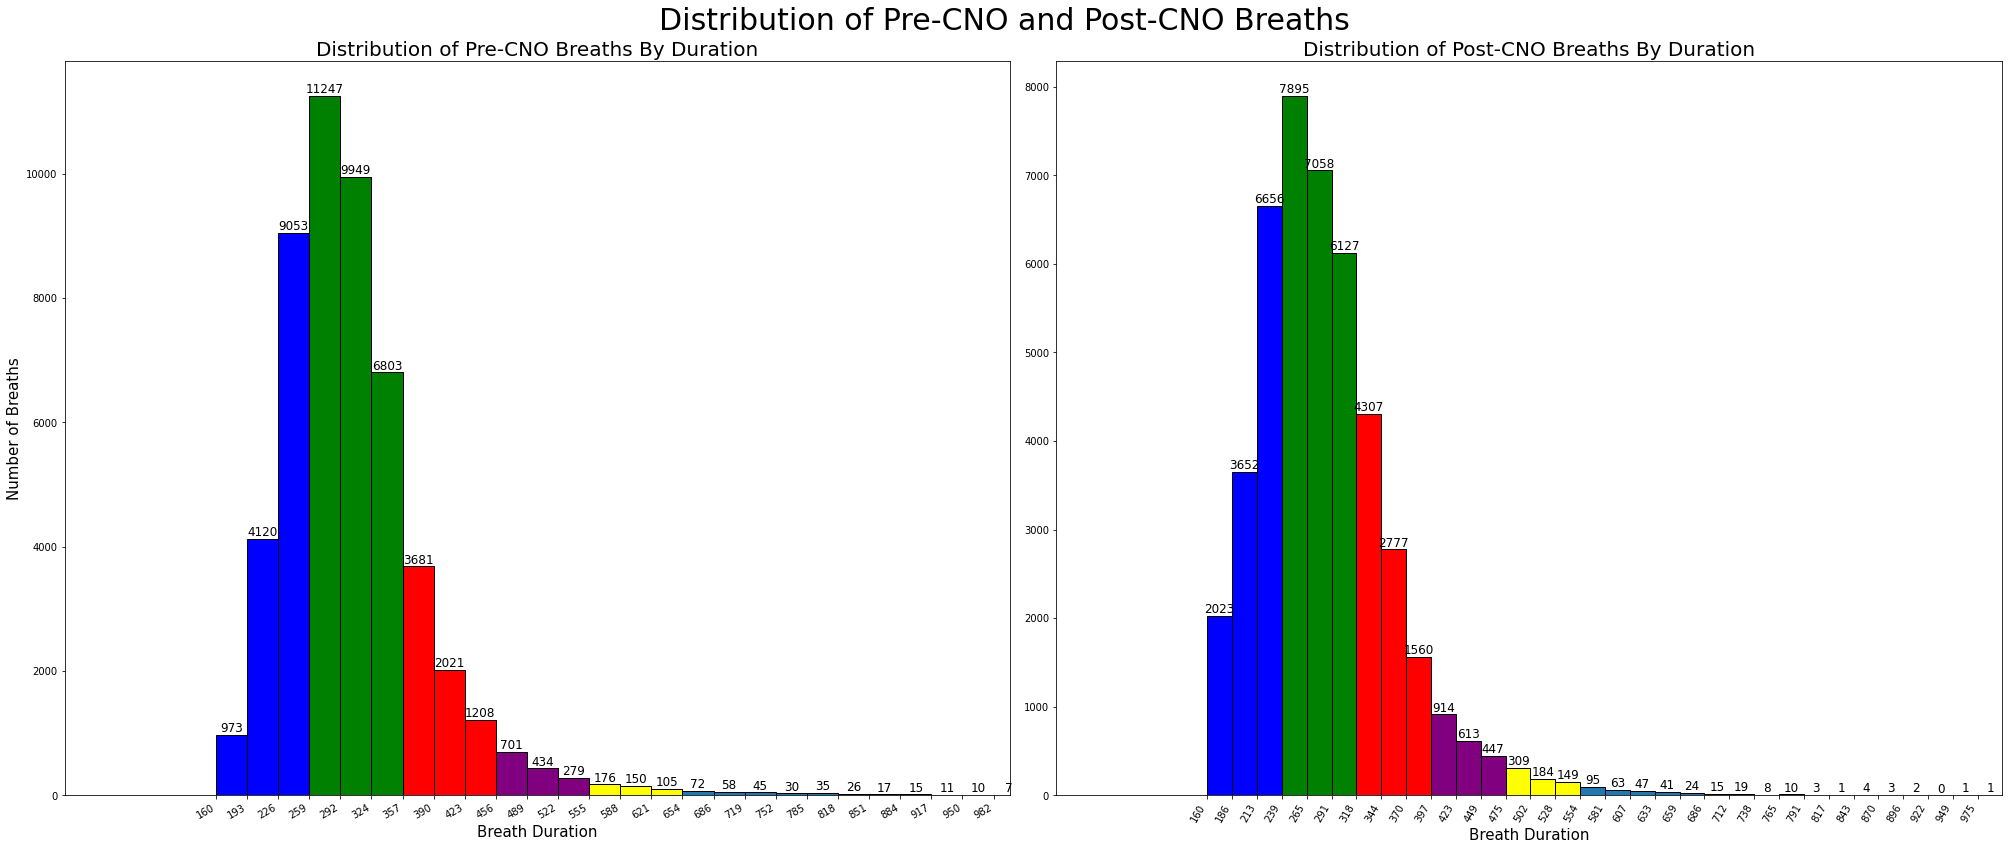

In [18]:
fig = plt.figure(figsize = (28,12))

plt.suptitle("Distribution of Pre-CNO and Post-CNO Breaths", size = 30)

ax = fig.add_subplot(1,2,1)

counts, bins, patches = ax.hist(all_per_cno, bins=70, edgecolor="black")
ax.set_xticks(bins, size=6) 
ax.set_xlabel("Breath Duration",size = 15)
ax.set_ylabel("Number of Breaths",size=15)
ax.set_title("Distribution of Pre-CNO Breaths By Duration", size=20)
ax.set_xlim(0,1000)
ax.bar_label(patches, size=12)
fig.autofmt_xdate()
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')


colourings = ["blue", "green", "red", "purple", "yellow"]
print(len(patches))
for i in range(0,15):
    patches[i].set_facecolor(colourings[math.floor(i/3)])

print(bins[0::5])
indices = list(range(0,len(bins),6))

sums = []
for index in indices:
    sums.append(sum(counts[index:index+5]))

print(sums)

ax = fig.add_subplot(1,2,2)

counts, bins, patches = ax.hist(all_post_cno, bins=70, edgecolor="black")
ax.set_xticks(bins, size=7) 
ax.set_xlabel("Breath Duration",size = 15)
ax.set_title("Distribution of Post-CNO Breaths By Duration",size=20)
ax.set_xlim(0,1000)
ax.bar_label(patches, size=12)
fig.autofmt_xdate()
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

colourings = ["blue", "green", "red", "purple", "yellow"]
print(len(patches))
for i in range(0,15):
    patches[i].set_facecolor(colourings[math.floor(i/3)])

print(bins[0::5])
indices = list(range(0,len(bins),6))

sums = []
for index in indices:
    sums.append(sum(counts[index:index+5]))

print(sums)
plt.tight_layout()
plt.savefig("pre_post_cno_dist2.jpg", dpi=300)

Multiple Alternative Methods for Grouping Breaths for the PCA Plots

In [9]:
phase_index_per_trial = defaultdict(lambda:defaultdict(list))
max_trial = 5
phases = [3,4,5,6]
current_index = 0
mtype = []
all_breaths = []
for trial in range(0,int(max_trial+1)):
    for mouse in custom_breathlists.keys():
        
        custom_breathlists[mouse].dropna(inplace=True)
        """
        if trial == 0:
            phases = [0,1,2]
        else:
            phases = [3,4,5,6]
        """
        for phase in phases:
            current_phase = custom_breathlists[mouse][(custom_breathlists[mouse]["Trial Number"] == trial) & (custom_breathlists[mouse]["Phase Number"] == phase)]

            genotype = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]
            
            phase_index_per_trial[trial][phase].append((current_index, current_index + len(current_phase)))

            current_index += len(current_phase)

            for index, row in current_phase.iterrows():
                padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
                all_breaths.append(padded)
                mtype.append(mtype2num[list(static_data[static_data["MUID"] == mouse]["Mouse Type"])[0]])

In [ ]:
########################################################
###########Plot Separately By Genotype##################
########################################################

phase_index_per_trial = defaultdict(lambda:defaultdict(list))
max_trial = 15
phases = [3,4,5,6]
current_index = 0
mtype = []
all_breaths = []
all_trials_nos = []

for mouse in custom_breathlists.keys():
    for phase in [0,1,2,3,4,5,6]:
        custom_breathlists[mouse].dropna(inplace=True)

        start = round(experiment_starter_timestamps[mouse] * 1000)

        current_phase = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == phase) & (custom_breathlists[mouse]["Breath Start Timestamp (ms)"] > start)]

        current_trials = np.array(current_phase["Trial Number"])

        genotype = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]

        phase_index_per_trial[genotype][phase].append((current_index, current_index + len(current_phase)))

        current_index += len(current_phase)

        all_trials_nos.append(current_trials)

        for index, row in current_phase.iterrows():
            padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
            all_breaths.append(padded)
            mtype.append(mtype2num[list(static_data[static_data["MUID"] == mouse]["Mouse Type"])[0]])

trials_array = np.hstack(all_trials_nos)

In [16]:
########################################################
###########Plot Separately By Genotype##################
########################################################

phase_index_per_trial = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
max_trial = 15
phases = [3,4,5,6]
current_index = 0
mtype = []
all_breaths = []
all_trials_nos = []

for trial in range(0,15):
    for mouse in custom_breathlists.keys():
        if trial == 0:
            phases = [0,1,2]
        else:
            phases = [3,4,5,6]
        for phase in phases:
            custom_breathlists[mouse].dropna(inplace=True)

            #start = round(experiment_starter_timestamps[mouse] * 1000)

            current_phase = custom_breathlists[mouse][(custom_breathlists[mouse]["Phase Number"] == phase) & (custom_breathlists[mouse]["Trial Number"] == trial)]

            current_trials = np.array(current_phase["Trial Number"])

            genotype = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]

            phase_index_per_trial[trial][genotype][phase].append((current_index, current_index + len(current_phase)))

            current_index += len(current_phase)

            all_trials_nos.append(current_trials)

            for index, row in current_phase.iterrows():
                padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
                all_breaths.append(padded)
                mtype.append(mtype2num[list(static_data[static_data["MUID"] == mouse]["Mouse Type"])[0]])

trials_array = np.hstack(all_trials_nos)

In [17]:
pca_data = np.vstack(all_breaths)

pca = PCA(n_components=6)
projection_3d = pca.fit(pca_data)
projection_3d = pca.fit_transform(all_breaths)

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_[:5]))

[0.46832383 0.26307824 0.10336622 0.06699397 0.03184577 0.02100594]
0.9336080288019891


In [64]:
#######################################################################
############## specifically for breath subsets ########################
#######################################################################
#247.4875  334.975
phase_index_per_trial = defaultdict(lambda:defaultdict(list))
max_trial = 15
phases = [3,4,5,6]
current_index = 0
mtype = []
all_breaths = []
for trial in range(0,int(max_trial+1)):
    for mouse in custom_breathlists.keys():
        for phase in phases:
            current_phase = custom_breathlists[mouse][(custom_breathlists[mouse]["Trial Number"] == trial) & (custom_breathlists[mouse]["Phase Number"] == phase) 
                            & (custom_breathlists[mouse]["Breath Start Timestamp (ms)"] > start) & (custom_breathlists[mouse]["Breath Duration (ms)"] <= 334.975) & 
                            (custom_breathlists[mouse]["Breath Duration (ms)"] >= 247.4875)]

            phase_index_per_trial[trial][phase].append((current_index, current_index + len(current_phase)))

            current_index += len(current_phase)

            for index, row in current_phase.iterrows():
                padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
                all_breaths.append(padded)
                mtype.append(mtype2num[list(static_data[static_data["MUID"] == mouse]["Mouse Type"])[0]])

Collecting Expiration Information

In [12]:
expiration_time = defaultdict(list)
for mouse in custom_breathlists.keys():
    mouse_type = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]
    expiration_time[(np.array(custom_breathlists[mouse]["Trial Number"])[-1],np.array(custom_breathlists[mouse]["Phase Number"])[-1])].append((mouse, mouse_type))

expiration_rounds = defaultdict(lambda : defaultdict(list))
survival_log = defaultdict(lambda:defaultdict(list))

for mousetype in static_data["Mouse Type"].unique():
    expiration_rounds[mousetype] =[]
    survival_log[mousetype] =[]

for mouse in custom_breathlists.keys():
    penultimate = np.array(custom_breathlists[mouse]["Trial Number"])[-1]
    mouse_type = static_data[static_data["MUID"] == mouse]["Mouse Type"].values[0]
    expiration_rounds[mouse_type].append(penultimate)

i=0
initials = [3,3,7,7]

for mousetype in static_data["Mouse Type"].unique():
    survival_log[mousetype].append(initials[i])
    i+=1

for trial in range(1,16):
    for mousetype in static_data["Mouse Type"].unique():
        if trial in expiration_rounds[mousetype]:
            survival_log[mousetype].append(survival_log[mousetype][-1] - expiration_rounds[mousetype].count(trial))
            for i in range(expiration_rounds[mousetype].count(trial)):
                expiration_rounds[mousetype].remove(trial)
        else:
            survival_log[mousetype].append(survival_log[mousetype][-1])

static_data["Mouse Type"] = static_data["Line"] + " " + static_data["Genotype"]

static_data[static_data["MUID"] == mouse]
count = 0
mtype2num = {}
for genotype in static_data["Mouse Type"].unique():
    mtype2num[genotype] = count
    count += 1

PCA Projections Plotting

In [18]:
#########################################################
###########Per genotype colored by trial number##########
#########################################################
from cProfile import label
from matplotlib import rc
import numpy as np
from pylab import *

import itertools
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("Full_3D_PCA_Per_Stage_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:3]),3)))

#overall plot 3d
fig= plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter3D(projection_3d[:,0], projection_3d[:,1], projection_3d[:,2],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)


#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)

data_per_phase_per_trial = defaultdict(lambda:defaultdict(int))

#per trial plots 3d

color = ["blue", "red", "green", "orange"]
for trial in range(0,15):
    if trial == 0:
        phases = [0,1,2]
    else:
        phases = [3,4,5,6]
    for phase in phases:

        fig = plt.figure(figsize=(16,16))
        plt.suptitle("Trial Number: {}, Phase: {}" .format(trial, number2phase[phase]), size = 30)
        figno=1

        colourings = ["navy", "crimson", "limegreen", "orange"]
        
        for group in mtype2num.keys():

            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][group][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            """cmap = mpl.cm.plasma
            bounds_list = range(0,16)
            bounds = bounds_list
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
"""
            ax = fig.add_subplot(2,2,figno, projection = '3d')
            ax.set_title("{}" .format(group), size = 20)
            my_plot = ax.scatter3D(projection_3d[indices_final,0],projection_3d[indices_final,1],projection_3d[indices_final,2],c = color[figno-1],rasterized=True)
                                    #c = np.array(trials_array)[indices_final], norm=norm, cmap=cmap, rasterized=True)

            ax.set_ylabel("2nd Principle Component")
            ax.set_zlabel("3rd Principle Component")
            ax.set_xlabel("1st Principle Component")

            """if figno == 2:
                plt.colorbar(my_plot, ax = ax, label = "Trial Number")"""
            
            figno += 1

        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)


    
pdf.close()


pdf = matplotlib.backends.backend_pdf.PdfPages("Full_2D_PCA_Per_Stage_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:2]),3)))

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter(projection_3d[:,0], projection_3d[:,1],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)

plt.tight_layout()
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])


pdf.savefig(fig)
plt.close(fig)

color = ["blue", "red", "green", "orange"]
for trial in range(0,15):        

    if trial == 0:
        phases = [0,1,2]
    else:
        phases = [3,4,5,6]

    for phase in phases:

        fig = plt.figure(figsize=(16,16))
        plt.suptitle("Trial Number: {}, Phase: {}" .format(trial, number2phase[phase]), size = 30)
        figno=1
        
        for group in mtype2num.keys():

            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][group][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            """cmap = mpl.cm.plasma
            bounds_list = range(0,16)
            bounds = bounds_list
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            """
            ax = fig.add_subplot(2,2,figno)
            ax.set_title("{}" .format(group), size = 20)
            my_plot = ax.scatter(projection_3d[indices_final,0],projection_3d[indices_final,1],c = color[figno-1],rasterized=True)
                                    #c = np.array(trials_array)[indices_final], norm=norm, cmap=cmap, rasterized=True)
            
            """if figno == 2:
                plt.colorbar(my_plot, ax = ax, label = "Trial Number")"""

            ax.set_ylabel("2nd Principle Axis")
            ax.set_xlabel("1st Principle Axis")

            figno += 1

        plt.tight_layout()

        if (trial,phase) in expiration_time.keys():
            txt = "Mice Expired:"
            for time in expiration_time[(trial,phase)]:
                txt += " " + str(time)
            plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
                
        pdf.savefig(fig)
        plt.close(fig)


pdf.close()

In [17]:
###################################
##########Per Phase Per Angle #####
###################################

from matplotlib import rc
import numpy as np
from pylab import *

import itertools
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("Full_3D_PCA_Per_Phase_Angle_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:3]),3)))
max_trial = 15

#overall plot 3d
fig= plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter3D(projection_3d[:,0], projection_3d[:,1], projection_3d[:,2],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)


#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)

data_per_phase_per_trial = defaultdict(lambda:defaultdict(int))

#per trial plots 3d

my3daxes = [(0,1,2), (0,2,1), (2,0,1),(1,0,2)]
myaxeslabels = {0 : "1st Principal Axis", 1: "2nd Principal Axis", 2 : "3rd Principal Axis"}

my2daxes = [(0,1), (1,2), (0,2)]

survival_log = {"hm3d Exp": 7, "hm3d Con": 7, "hm4d Exp": 3, "hm4d Con": 3}

for trial in range(0,int(max_trial+1)):
    
    if trial == 0:
        phases = [0,1,2]
    else:    
        phases = [3,4,5,6]

    for phase in phases:

        fig = plt.figure(figsize=(16,16))
        plt.suptitle("Trial Number: {}, Phase: {}" .format(trial, number2phase[phase]), size = 30)
        figno=1

        colourings = ["navy", "crimson", "limegreen", "orange"]
                    
        indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
        indices_final = list(itertools.chain.from_iterable(indices))
        
        for angle in range(0,len(my3daxes)):

            cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

            ax = fig.add_subplot(2,2,figno, projection = '3d')
            ax.set_title("Angle {}" .format(figno), size = 20)
            my_plot = ax.scatter3D(projection_3d[indices_final,my3daxes[angle][0]],projection_3d[indices_final,my3daxes[angle][1]],projection_3d[indices_final,my3daxes[angle][2]],
                                    c = np.array(mtype)[indices_final], norm=norm, cmap=cmap, rasterized=True)

            ax.set_ylabel(myaxeslabels[my3daxes[angle][1]])
            ax.set_zlabel(myaxeslabels[my3daxes[angle][2]])
            ax.set_xlabel(myaxeslabels[my3daxes[angle][0]])

            if figno == 2:
                cbar = plt.colorbar(my_plot, ticks=np.linspace(0,3,4), ax=ax)#, cax = cbar_ax)
                cbar.set_ticklabels([genotype + ": \n Alive: {} Mice" .format(survival_log[genotype]) for genotype in mtype2num.keys()])
            
            figno += 1

        plt.tight_layout()

        if (trial,phase) in expiration_time.keys():
            txt = "Mice Expired:"
            for time in expiration_time[(trial,phase)]:
                txt += " " + str(time)
                for gtype in mtype2num.keys():
                    if time[1] == gtype:
                        survival_log[gtype] -= 1
            plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
    
        pdf.savefig(fig)
        plt.close(fig)


    
pdf.close()


pdf = matplotlib.backends.backend_pdf.PdfPages("Full_2D_PCA_Per_Phase_Per_Angle_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:2]),3)))

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter(projection_3d[:,0], projection_3d[:,1],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)

plt.tight_layout()
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])


pdf.savefig(fig)
plt.close(fig)

survival_log = {"hm3d Exp": 7, "hm3d Con": 7, "hm4d Exp": 3, "hm4d Con": 3}

for trial in range(0,int(max_trial+1)):
    
    if trial == 0:
        phases = [0,1,2]
    else:
        phases = [3,4,5,6]
        
    for phase in phases:

        fig = plt.figure(figsize=(16,16))
        plt.suptitle("Trial Number: {}, Phase: {}" .format(trial, number2phase[phase]), size = 30)
        figno=1
            
        indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
        indices_final = list(itertools.chain.from_iterable(indices))
        
        for angle in range(0,len(my3daxes)):

            if figno == 4:
                cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

                ax = fig.add_subplot(2,2,figno, projection = '3d')
                ax.set_title("3D Projection", size = 20)
                my_plot = ax.scatter3D(projection_3d[indices_final,0],projection_3d[indices_final,1],projection_3d[indices_final,2],
                                        c = np.array(mtype)[indices_final], norm=norm,cmap=cmap, rasterized=True)
                
                ax.set_ylabel("2nd Principal Axis")
                ax.set_xlabel("1st Principal Axis")
                ax.set_zlabel("3rd Principal Axis")

                cbar = plt.colorbar(my_plot, ticks=np.linspace(0,3,4), ax=ax)#, cax = cbar_ax)
                cbar.set_ticklabels([genotype + ": \n Alive: {} Mice" .format(survival_log[genotype]) for genotype in mtype2num.keys()])
            else:
                cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

                ax = fig.add_subplot(2,2,figno)
                ax.set_title("Angle {}" .format(figno), size = 20)
                my_plot = ax.scatter(projection_3d[indices_final,my2daxes[angle][0]],projection_3d[indices_final,my2daxes[angle][1]],
                                        c = np.array(mtype)[indices_final], norm=norm, cmap=cmap, rasterized=True)
                
                ax.set_ylabel(myaxeslabels[my2daxes[angle][1]])
                ax.set_xlabel(myaxeslabels[my2daxes[angle][0]])

            figno += 1

        plt.tight_layout()

        if (trial,phase) in expiration_time.keys():
            txt = "Mice Expired:"
            for time in expiration_time[(trial,phase)]:
                txt += " " + str(time)
                for gtype in mtype2num.keys():
                    if time[1] == gtype:
                        survival_log[gtype] -= 1
            plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=20)
                    
        pdf.savefig(fig)
        plt.close(fig)


pdf.close()

In [35]:
from matplotlib import rc
import numpy as np
from pylab import *

import itertools
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("Till_Exp_3D_PCA_Per_Trial_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:3]),3)))
max_trial = 5
#overall plot 3d
fig= plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter3D(projection_3d[:,0], projection_3d[:,1], projection_3d[:,2],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)


#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)

data_per_phase_per_trial = defaultdict(lambda:defaultdict(int))

#per trial plots 3d

for trial in range(0,int(max_trial+1)):
    fig = plt.figure(figsize=(12,12))
    plt.suptitle("Trials Until Expiration: {}" .format(trial), size = 30)
    figno=1

    
    for phase in phases:
        indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
        indices_final = list(itertools.chain.from_iterable(indices))

        cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
        norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

        ax = fig.add_subplot(2,2,figno, projection = '3d')
        ax.set_title(number2phase[phase], size = 20)
        my_plot = ax.scatter3D(projection_3d[indices_final,0],projection_3d[indices_final,1],projection_3d[indices_final,2],
                                cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
        
        ax.set_ylabel("2nd Principal Component")
        ax.set_zlabel("3rd Principal Component")

        if (trial,phase) in expiration_time.keys():
            txt = "Mice Expired:"
            for time in expiration_time[(trial,phase)]:
                txt += " " + str(time)
            ax.set_xlabel('''1st Principal Component
            {}''' .format(txt), size = 15)
        else:
            ax.set_xlabel("1st Principal Component")
        ax.set_xlabel("1st Principal Component")
        figno += 1

        if figno == 3:
            #cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
            cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
            cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

    plt.tight_layout()
   
    pdf.savefig(fig)
    plt.close(fig)

    
pdf.close()


pdf = matplotlib.backends.backend_pdf.PdfPages("Till_Exp_2D_PCA_Per_Trial_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:2]),3)))

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter(projection_3d[:,0], projection_3d[:,1],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)

plt.tight_layout()
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])


pdf.savefig(fig)
plt.close(fig)


for trial in range(0,int(max_trial+1)):
    fig = plt.figure(figsize=(16,16))
    plt.suptitle("Trials Until Expiration: {}" .format(trial), size = 30)
    figno=1
    
    cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)
    
    for phase in phases:
        indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
        indices_final = list(itertools.chain.from_iterable(indices))

        ax = fig.add_subplot(2,2,figno)
        ax.set_title(number2phase[phase], size = 20)
        my_plot = ax.scatter(projection_3d[indices_final,0],projection_3d[indices_final,1],
                            cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
        ax.set_xlabel("1st Principal Component")
        ax.set_ylabel("2nd Principal Component")
        if (trial,phase) in expiration_time.keys():
            txt = "Mice Expired:"
            for time in expiration_time[(trial,phase)]:
                txt += " " + str(time)
            ax.set_xlabel('''1st Principal Component
            {} ''' .format(txt), size = 15)
        else:
            ax.set_xlabel("1st Principal Component")
        ax.set_xlabel("1st Principal Component")
        figno += 1
    
        
        #cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
        if figno == 3:
            cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
            cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])
        
    plt.tight_layout()
    pdf.savefig()
    
    plt.close(fig)

pdf.close()

In [13]:
from matplotlib import rc
import numpy as np
from pylab import *

import itertools
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("Full_3D_PCA_Per_Phase_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:3]),3)))
max_trial = 15
#overall plot 3d
fig= plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter3D(projection_3d[:,0], projection_3d[:,1], projection_3d[:,2],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)


#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

plt.tight_layout()
pdf.savefig(fig)
plt.close(fig)

data_per_phase_per_trial = defaultdict(lambda:defaultdict(int))

#per trial plots 3d

for trial in range(0,int(max_trial+1)):
    fig = plt.figure(figsize=(12,12))
    plt.suptitle("Trial Number: {}" .format(trial), size = 30)
    figno=1

    if trial == 0:
        for phase in [0,1,2]:
            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N) 

            ax = fig.add_subplot(2,2,figno, projection = '3d')
            ax.set_title(number2phase[phase], size = 20)
            my_plot = ax.scatter3D(projection_3d[indices_final,0],projection_3d[indices_final,1],projection_3d[indices_final,2],
                                    cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
            
            ax.set_ylabel("2nd Principal Component")
            ax.set_ylabel("3rd Principal Component")

            if (trial,phase) in expiration_time.keys():
                txt = "Mice Expired:"
                for time in expiration_time[(trial,phase)]:
                    txt += " " + str(time)
                ax.set_xlabel('''1st Principal Component
                {}''' .format(txt), size = 15)
            else:
                ax.set_xlabel("1st Principal Component")
            #ax.set_xlabel("1st Principal Component")
            figno += 1

            if figno == 3:
                #cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
                cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
                cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])
    else:    
        for phase in phases:
            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N) 

            ax = fig.add_subplot(2,2,figno, projection = '3d')
            ax.set_title(number2phase[phase], size = 20)
            my_plot = ax.scatter3D(projection_3d[indices_final,0],projection_3d[indices_final,1],projection_3d[indices_final,2],
                                    cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
            
            ax.set_ylabel("2nd Principal Component")
            ax.set_ylabel("3rd Principal Component")

            if (trial,phase) in expiration_time.keys():
                txt = "Mice Expired:"
                for time in expiration_time[(trial,phase)]:
                    txt += " " + str(time)
                ax.set_xlabel('''1st Principal Component
                {}''' .format(txt), size = 15)
            else:
                ax.set_xlabel("1st Principal Component")
            #ax.set_xlabel("1st Principal Component")
            figno += 1

            if figno == 3:
                #cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
                cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
                cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])

    plt.tight_layout()
   
    pdf.savefig(fig)
    plt.close(fig)

    
pdf.close()


pdf = matplotlib.backends.backend_pdf.PdfPages("Full_2D_PCA_Per_Trial_Per_Genotype_EVR_{}.pdf" .format(round(np.sum(pca.explained_variance_ratio_[:2]),3)))

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
plt.suptitle("PCA Showing All Data", size = 30)

cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N)

my_plot=ax.scatter(projection_3d[:,0], projection_3d[:,1],
             cmap=cmap, norm=norm, c = np.array(mtype), rasterized=True)

plt.tight_layout()
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])


pdf.savefig(fig)
plt.close(fig)


for trial in range(0,int(max_trial+1)):
    fig = plt.figure(figsize=(16,16))
    plt.suptitle("Trial Number: {}" .format(trial), size = 30)
    figno=1
    
    if trial == 0:
        for phase in [0,1,2]:
            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N) 

            ax = fig.add_subplot(2,2,figno)
            ax.set_title(number2phase[phase], size = 20)
            my_plot = ax.scatter(projection_3d[indices_final,0],projection_3d[indices_final,1],
                                cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
            ax.set_xlabel("1st Principal Component")
            ax.set_ylabel("2nd Principal Component")
            if (trial,phase) in expiration_time.keys():
                txt = "Mice Expired:"
                for time in expiration_time[(trial,phase)]:
                    txt += " " + str(time)
                ax.set_xlabel('''1st Principal Component
                {} ''' .format(txt), size = 15)
            else:
                ax.set_xlabel("1st Principal Component")
            #ax.set_xlabel("1st Principal Component")
            figno += 1            

    else:    
        for phase in phases:
            indices = list([list(range(x[0],x[1])) for x in phase_index_per_trial[trial][phase]])
            indices_final = list(itertools.chain.from_iterable(indices))

            cmap = mpl.colors.ListedColormap(["navy", "crimson", "limegreen", "orange"])
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5,4), cmap.N) 

            ax = fig.add_subplot(2,2,figno)
            ax.set_title(number2phase[phase], size = 20)
            my_plot = ax.scatter(projection_3d[indices_final,0],projection_3d[indices_final,1],
                                cmap=cmap, norm=norm, c = np.array(mtype)[indices_final], rasterized=True)
            ax.set_xlabel("1st Principal Component")
            ax.set_ylabel("2nd Principal Component")
            if (trial,phase) in expiration_time.keys():
                txt = "Mice Expired:"
                for time in expiration_time[(trial,phase)]:
                    txt += " " + str(time)
                ax.set_xlabel('''1st Principal Component
                {} ''' .format(txt), size = 15)
            else:
                ax.set_xlabel("1st Principal Component")
            #ax.set_xlabel("1st Principal Component")
            figno += 1
        
            
            #cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
            if figno == 3:
                cbar = fig.colorbar(my_plot, ticks=np.linspace(0,3,4))#, cax = cbar_ax)
                cbar.set_ticklabels([genotype for genotype in mtype2num.keys()])
        
    plt.tight_layout()
    pdf.savefig()
    
    plt.close(fig)

pdf.close()

Concatenating All Breaths and Relevant Information

In [8]:
breath_durations = []
mouseID = []
phase_labels = []
all_breaths = []
breath_heights = []
rounds_till_death = []
genotypes = []
trial_number = []

standardized = 1    #identify whether to standardize all breaths to 1000 ms and individually normalized breath heights

for mouse in custom_breathlists.keys():

    custom_breathlists[mouse].dropna(inplace=True)

    start = round(experiment_starter_timestamps[mouse] * 1000)

    net_breaths = custom_breathlists[mouse][custom_breathlists[mouse]["Breath Start Timestamp (ms)"] > start]

    breath_durations.append(np.array(net_breaths["Breath Duration (ms)"]))

    breath_heights.append(np.array(net_breaths["Breath Height"]))

    trial_number.append(np.array(net_breaths["Trial Number"]))

    rounds_till_death.append(np.array(net_breaths["Trials Till Expiration"]))

    phase_labels.append(np.array(net_breaths["Phase Number"]))

    genotypes.append(np.array(net_breaths["Genotype"]))

    mouseID.append(np.array(net_breaths["Mouse ID"]))

    for index, row in net_breaths.iterrows():
        
        if standardized:
            breath = row["Breath Data"]

            if len(breath) > 1000:
                adjusted = signal.resample(breath,1000)
            elif len(breath) < 1000:
                x_interp = np.arange(0,len(breath),(len(breath))/1000)
                adjusted = np.interp(x_interp,np.arange(0,len(breath),1),breath)
            else:
                adjusted = breath

            all_breaths.append(adjusted[:1000]/np.max(adjusted[:1000]))
        else:
            padded = np.pad(row["Breath Data"], (0,2500-np.shape(row["Breath Data"])[0]), "constant")
            all_breaths.append(padded)

durations_array = np.hstack(breath_durations)
heights_array = np.hstack(breath_heights)
rounds_till_death = np.hstack(rounds_till_death)
phase_labels_array  = np.hstack(phase_labels)
trial_number_array = np.hstack(trial_number)
genotypes = np.hstack(genotypes)
mtype = np.hstack(genotypes)
mouseID_array = np.hstack(mouseID)


Visualizing Breath Modification

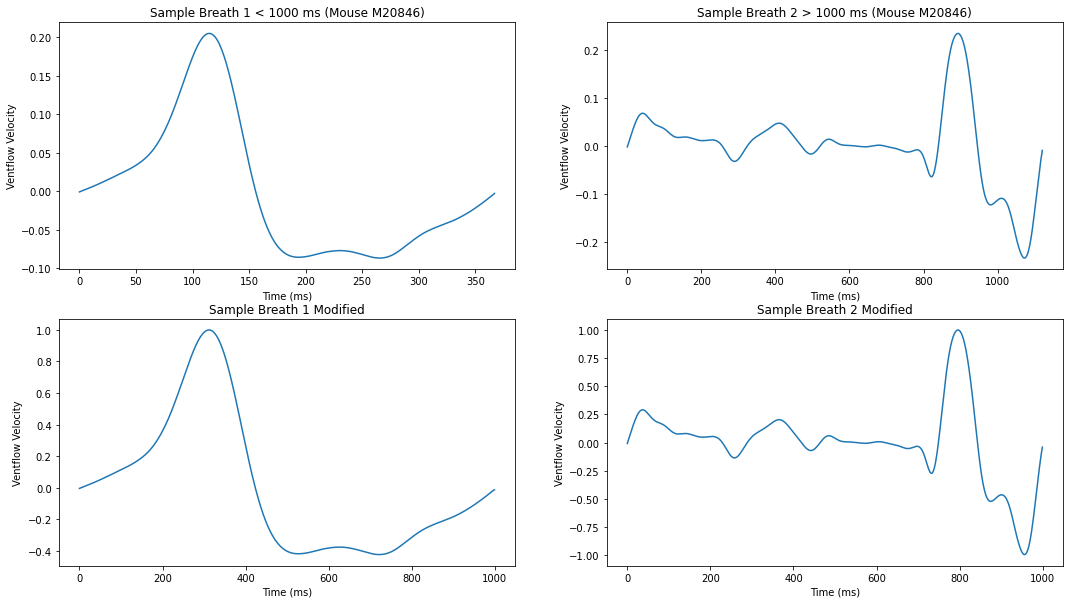

In [15]:
fig = plt.figure(figsize = (18,10))

ax = fig.add_subplot(2,2,1)
plt.title("Sample Breath 1 < 1000 ms (Mouse M20846)")
plt.plot(custom_breathlists["M20864"]["Breath Data"][140])
plt.xlabel("Time (ms)",size=10)
plt.ylabel("Ventflow Velocity",size=10)

ax = fig.add_subplot(2,2,3)
plt.title("Sample Breath 1 Modified")
x_interp = np.arange(0,len(custom_breathlists["M20864"]["Breath Data"][140]),(len(custom_breathlists["M20864"]["Breath Data"][140]))/1000)
interpolated_breath = np.interp(x_interp,np.arange(0,len(custom_breathlists["M20864"]["Breath Data"][140]),1),custom_breathlists["M20864"]["Breath Data"][140])
plt.plot(interpolated_breath/np.max(interpolated_breath))
plt.xlabel("Time (ms)",size=10)
plt.ylabel("Ventflow Velocity",size=10)

ax = fig.add_subplot(2,2,2)
plt.title("Sample Breath 2 > 1000 ms (Mouse M20846)")
plt.plot(custom_breathlists["M20864"]["Breath Data"][1178])
plt.xlabel("Time (ms)",size=10)
plt.ylabel("Ventflow Velocity",size=10)

ax = fig.add_subplot(2,2,4)
plt.title("Sample Breath 2 Modified")
breath = custom_breathlists["M20864"]["Breath Data"][1178]
adjusted = signal.resample(breath,1000)
plt.plot(adjusted/np.max(adjusted))
plt.xlabel("Time (ms)",size=10)
plt.ylabel("Ventflow Velocity",size=10)

fig.savefig("modifying_break.jpg", dpi = 300)

Visualizing Overall Breath Duration Distribution

80
[ 160.      305.8125  451.625   597.4375  743.25    889.0625 1034.875
 1180.6875 1326.5    1472.3125 1618.125  1763.9375 1909.75   2055.5625
 2201.375  2347.1875 2493.    ]
[136702.0, 53579.0, 5758.0, 2049.0, 1039.0, 528.0, 280.0, 144.0, 118.0, 95.0, 78.0, 59.0, 48.0, 15.0]


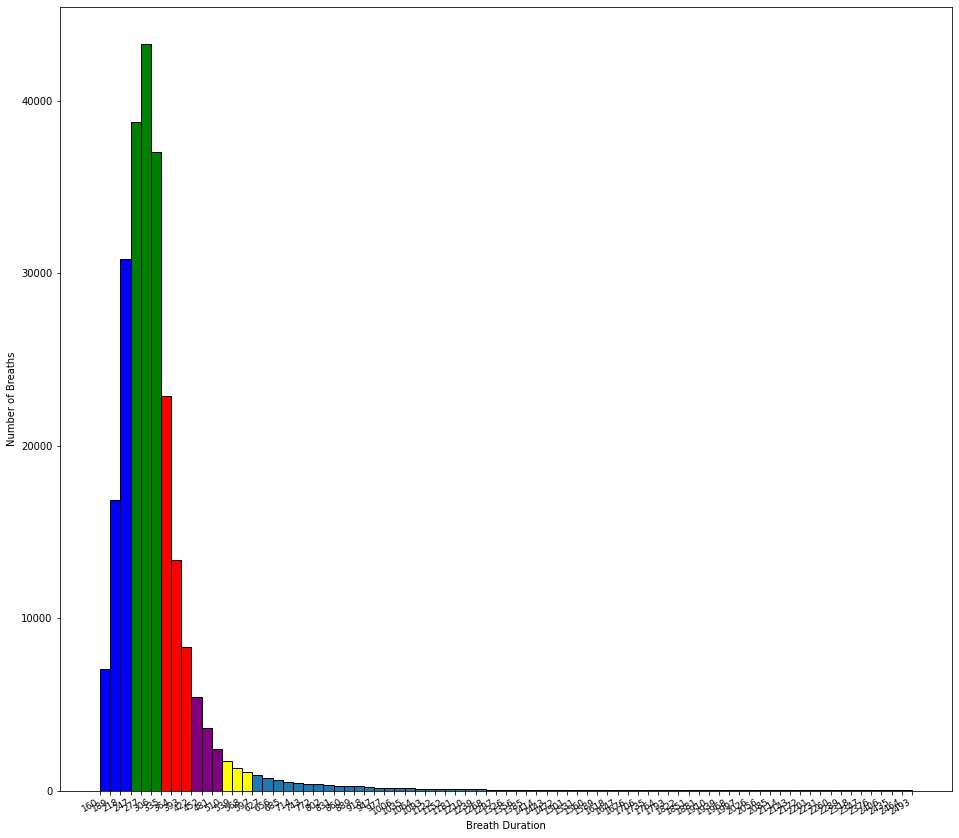

In [16]:
fig = plt.figure(figsize = (16,16))
counts, bins, patches = plt.hist(durations_array, bins=80, edgecolor="black")
plt.xticks(bins, size=9) 
plt.xlabel("Breath Duration")
plt.ylabel("Number of Breaths")
fig.autofmt_xdate()

colourings = ["blue", "green", "red", "purple", "yellow"]
print(len(patches))
for i in range(0,15):
    patches[i].set_facecolor(colourings[math.floor(i/3)])

print(bins[0::5])
indices = list(range(0,len(bins),6))

sums = []
for index in indices:
    sums.append(sum(counts[index:index+5]))

print(sums)

plt.show()

PCA and Clustering

In [12]:
all_breaths_concat = np.array(all_breaths)

pca = PCA(n_components=6)
projection_3d = pca.fit(all_breaths_concat)
projection_3d = pca.fit_transform(all_breaths_concat)

print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.47546109 0.26404265 0.09970713 0.06173694 0.03751451 0.01820314]
0.9566654615803017


In [13]:
import warnings
warnings.filterwarnings('ignore')

Determining Number of Clusters to Use in K-Means Clustering

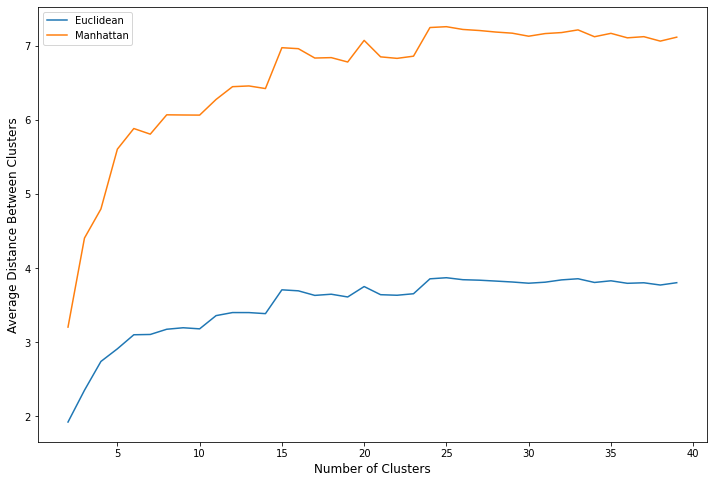

In [18]:
from scipy.spatial.distance import cityblock
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler

avg_euc_distances = {}
avg_man_distances = {}

breath_ranges = [(0,300),(300,500),(500,1000),(1000,2500)]


if standardized:
    data = StandardScaler().fit_transform(projection_3d[:,:5])

    for cluster_no in range(2,40):
        clustering = KMeans(n_clusters=cluster_no, init='k-means++', n_init=12, max_iter=700).fit(data)
        euc_distances = []
        man_distances = []

        centers = clustering.cluster_centers_

        for row in range(0,np.shape(clustering.cluster_centers_)[0]):
            for row2 in range(row+1,np.shape(clustering.cluster_centers_)[0]):
                euc_distances.append(np.linalg.norm(centers[row,:]-centers[row2,:]))
                man_distances.append(cityblock(centers[row,:],centers[row2,:]))
                
        avg_euc_distances[cluster_no] = np.mean(euc_distances)
        avg_man_distances[cluster_no] = np.mean(man_distances)

    
    fig = plt.figure(figsize=(12,8))

    plt.plot(list(avg_euc_distances.keys()), list(avg_euc_distances.values()), label = "Euclidean")
    plt.plot(list(avg_man_distances.keys()), list(avg_man_distances.values()), label = "Manhattan")
    plt.xlabel("Number of Clusters", size = 12)
    plt.ylabel("Average Distance Between Clusters", size = 12)
    #plt.title("Average Distance Between Clusters", size = 18)
    plt.legend()

else:

    fig = plt.figure(figsize=(16,16))
    plt.suptitle("Avg Distances Between Clusters Usings K-Means" , size = 30)
    figno=1

    for i in range(0,len(breath_ranges)):

        breath_low = breath_ranges[i][0]
        breath_high = breath_ranges[i][1]

        current_bin_indices = np.where((durations_array >= breath_low) & (durations_array <= breath_high))

        current_bin = projection_3d[current_bin_indices[0]]

        data = StandardScaler().fit_transform(current_bin)

        for cluster_no in range(2,30):

            clustering = KMeans(n_clusters=cluster_no, init='k-means++', n_init=12, max_iter=500).fit(data)

            euc_distances = []
            man_distances = []

            centers = clustering.cluster_centers_

            for row in range(0,np.shape(clustering.cluster_centers_)[0]):
                for row2 in range(row+1,np.shape(clustering.cluster_centers_)[0]):
                    euc_distances.append(np.linalg.norm(centers[row,:]-centers[row2,:]))
                    man_distances.append(cityblock(centers[row,:],centers[row2,:]))
                    
            avg_euc_distances[cluster_no] = np.mean(euc_distances)
            avg_man_distances[cluster_no] = np.mean(man_distances)

        ax = fig.add_subplot(2,2,figno, projection = '3d')
        ax.set_title("{} to {} ms Breaths, # of breaths: {}".format(round(breath_low),round(breath_high),np.shape(data)[0]), size = 20)

        ax = fig.add_subplot(2,2,figno)

        ax.plot(list(avg_euc_distances.keys()), list(avg_euc_distances.values()), label = "Euclidean")
        ax.plot(list(avg_man_distances.keys()), list(avg_man_distances.values()), label = "Manhattan")
        ax.set_xlabel("Number of Clusters")
        ax.set_ylabel("Average Distance Between Clusters")
        ax.legend()

        figno += 1
        plt.tight_layout()

fig.savefig("cluster_vs_distance1.jpg", dpi=300)

Clustering

In [13]:
from sklearn.preprocessing import StandardScaler

breath_ranges = [(0,300),(300,500),(500,1000),(1000,2500)]
cluster_numbers = [12, 11, 9, 8]

standardized = 1

if standardized == 1:
    breath_ranges = [(0,1001)]
    cluster_numbers = [15]

clustering_centers = {}
clustering_labels = {}


for i in range(0,len(breath_ranges)):

    breath_low = breath_ranges[i][0]
    breath_high = breath_ranges[i][1]

    if standardized:
        data = StandardScaler().fit_transform(projection_3d[:,:5])
    else:
        current_bin_indices = np.where((durations_array >= breath_low) & (durations_array <= breath_high))

        current_bin = projection_3d[current_bin_indices[0]]

        data = StandardScaler().fit_transform(current_bin[:,:5])

    clustering = KMeans(n_clusters=cluster_numbers[i], init='k-means++', n_init=8, max_iter=300).fit(data)

    clustering_centers[i] = clustering.cluster_centers_

    clustering_labels[i] = clustering.labels_

Analysis of Cluster Charactersitics

In [14]:
from scipy import stats
import openpyxl

breath_ranges = [(160,300),(300,500),(500,1000),(1000,2500)]

all_dataframes = {}

if standardized == 1:
    breath_ranges = [(0,1000)]
    cluster_numbers = [15]

for i in range(0,len(breath_ranges)):

    breath_low = breath_ranges[i][0]
    breath_high = breath_ranges[i][1]

    if standardized:
        current_bin_indices = (range(0,np.shape(projection_3d)[0]),0)
    else:
        current_bin_indices = np.where((durations_array >= breath_low) & (durations_array <= breath_high))

    current_bin_breaths = all_breaths_concat[current_bin_indices[0]]

    current_bin_durations = durations_array[current_bin_indices[0]]

    current_bin_heights = heights_array[current_bin_indices[0]]

    current_bin_genotype = genotypes[current_bin_indices[0]]

    current_bin_phases = phase_labels_array[current_bin_indices[0]]

    current_bin_rounds_till = rounds_till_death[current_bin_indices[0]]

    clusters = list(set(clustering_labels[i]))

    durations_means = []
    durations_median = []
    durations_var = []
    durations_mode = []

    height_means = []
    height_median = []
    height_mode = []
    height_var = []

    rounds_till_Expiration_mean = []
    rounds_till_Expiration_median = []
    rounds_till_Expiration_mode = []
    rounds_till_Expiration_var = []

    
    for cluster in clusters:

        current_cluster_indices = np.where(np.array(clustering_labels[i]) == cluster)

        current_durations = current_bin_durations[current_cluster_indices]

        current_heights = current_bin_heights[current_cluster_indices]

        current_rtd = current_bin_rounds_till[current_cluster_indices]

        durations_means.append(np.mean(current_durations))
        durations_var.append(np.var(current_durations))
        durations_median.append(np.median(current_durations))
        durations_mode.append(stats.mode(np.around(current_durations, decimals=2))[0][0])

        height_means.append(np.mean(current_heights))
        height_median.append(np.median(current_heights))
        height_mode.append(stats.mode(np.around(current_heights, decimals=2))[0][0])
        height_var.append(np.var(current_heights))

        rounds_till_Expiration_mean.append(np.mean(current_rtd))
        rounds_till_Expiration_median.append(np.median(current_rtd))
        rounds_till_Expiration_mode.append(stats.mode(np.around(current_rtd, decimals=2))[0][0])
        rounds_till_Expiration_var.append(np.var(current_rtd))

        df1 = pd.DataFrame(data = list(zip(clusters, durations_means, durations_var, durations_median, durations_mode,
                                    height_means, height_var, height_median, height_mode,
                                    rounds_till_Expiration_mean, rounds_till_Expiration_var, rounds_till_Expiration_median, rounds_till_Expiration_mode)),
                            columns = ["Cluster Number", "Breath Durations Mean", "Breath Durations Variance", "Breath Durations Median", "Breath Durations Mode",
                                        "Breath Heights Mean", "Breath Heights Variance", "Breath Heights Median", "Breath Heights Mode",
                                        "Rounds Till Expiration Mean", "Rounds Till Expiration Variance", "Rounds Till Expiration Median", "Rounds Till Expiration Mode",
                            ]
                            )

    all_dataframes[i] = df1

with pd.ExcelWriter('standardized_breath_clusters_summary_statistics.xlsx') as writer:
    for i in range(0,len(breath_ranges)):
        all_dataframes[i].to_excel(writer, sheet_name='{}_to_{}ms'.format(breath_ranges[i][0],breath_ranges[i][1]))

In [55]:
import matplotlib.backends.backend_pdf

figure_sizes = [(4,3),(4,3),(3,3),(3,3)]
axes_limits = [(-0.35,0.6),(-0.32,0.6),(-0.3,0.8),(-0.25,0.62)]

if standardized == 1:
    figure_sizes = [(5,3),(4,3),(3,3),(3,3)]

for i in range(0,len(breath_ranges)):

    breath_low = breath_ranges[i][0]
    breath_high = breath_ranges[i][1]

    if standardized == 1:
        pdf = matplotlib.backends.backend_pdf.PdfPages("Standardized_Breaths_{}ms.pdf" .format(breath_high))
        current_bin_indices = (range(0,np.shape(projection_3d)[0]),0)
    else:
        pdf = matplotlib.backends.backend_pdf.PdfPages("Avg_Breaths_{}_to_{}ms.pdf" .format(breath_low,breath_high))
        current_bin_indices = np.where((durations_array >= breath_low) & (durations_array <= breath_high))

    current_bin_breaths = all_breaths_concat[current_bin_indices[0]]

    clusters = list(set(clustering_labels[i]))
    
    figno = 1

    fig = plt.figure(figsize=(7*figure_sizes[i][0],7*figure_sizes[i][1]))
    plt.suptitle("Average Breaths By Cluster for Breaths {} to {} ms" .format(breath_low,breath_high), size = 32)

    for cluster in clusters:

        current_cluster_indices = np.where(np.array(clustering_labels[i]) == cluster)

        current_breaths = current_bin_breaths[current_cluster_indices,:]

        average_breath = np.sum(current_breaths[0], axis=0) / np.shape(current_breaths[0])[0]

        ax = fig.add_subplot(math.ceil(len(clusters)/3),3, figno)

        ax.plot(average_breath)
        ax.set_title("Cluster Number {}, # of Breaths: {}" .format(cluster, np.shape(current_breaths[0])[0]), size = 25)

        ax.set_xlabel("Time (ms)", size = 20)
        ax.set_ylabel("Vent Flow", size = 20)
        if standardized == 1:
            ax.set_ylim(-1,1)
        else:
            ax.set_ylim(axes_limits[i][0],axes_limits[i][1])
        ax.set_xlim(0,breath_high)

        figno += 1

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)
    
    """    columns = ["Cluster Number", "Breath Durations Mean", "Breath Durations Variance", "Breath Durations Median", "Breath Durations Mode",
                                        "Breath Heights Mean", "Breath Heights Variance", "Breath Heights Median", "Breath Heights Mode",
                                        "Rounds Till Expiration Mean", "Rounds Till Expiration Variance", "Rounds Till Expiration Median", "Rounds Till Expiration Mode","""

    fig = plt.figure(figsize=(28,21))
    plt.suptitle("Cluster Summary Statistics for Breaths {} to {} ms" .format(breath_low,breath_high), size = 32)


    metrics = ["Breath Durations","Breath Heights","Rounds Till Expiration"]
    summary_metrics = ["Mean", "Variance", "Median", "Mode"]

    colouring = {metrics[0]:"red",metrics[1]:"blue",metrics[2]:"green"}

    figno = 1
    for summary_metric in summary_metrics:
        for metric in metrics:    
            ax = fig.add_subplot(4,3,figno)
            ax.bar(clusters,list(np.array(all_dataframes[i]["{} {}".format(metric,summary_metric)])), width = 0.4, color = colouring[metric])
            ax.set_title("{} {} By Cluster" .format(metric, summary_metric), size = 25)
            ax.set_xlabel("Cluster Number",size=20)
            ax.set_ylabel("{}" .format(summary_metric),size=20)
            if metric == "Breath_Durations":
                ax.set_ylim(breath_ranges[i][0],breath_ranges[i][1])
            figno += 1
            
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)
    
    pdf.close()

In [ ]:
from collections import Counter
import math

if standardized:
  breath_ranges = [(0,1000)]
else:
  breath_ranges = [(0,300),(300,500),(500,1000),(1000,2500)]

import matplotlib.backends.backend_pdf

for i in range(0,len(breath_ranges)):

    breath_low = breath_ranges[i][0]
    breath_high = breath_ranges[i][1]

    if standardized == 1:
      pdf = matplotlib.backends.backend_pdf.PdfPages("Cluster_Info_Standardized_Breaths_{}ms.pdf" .format(breath_high))
      current_bin_indices = (range(0,np.shape(projection_3d)[0]),0)
    else: 
      pdf = matplotlib.backends.backend_pdf.PdfPages("Cluster_Info_Breaths_{}_to_{}ms.pdf" .format(breath_low,breath_high))
      current_bin_indices = np.where((durations_array >= breath_low) & (durations_array <= breath_high))


    current_bin_breaths = all_breaths_concat[current_bin_indices[0]]

    current_bin_durations = durations_array[current_bin_indices[0]]

    current_bin_heights = heights_array[current_bin_indices[0]]

    current_bin_genotype = genotypes[current_bin_indices[0]]

    current_bin_phases = phase_labels_array[current_bin_indices[0]]

    current_bin_rounds_till = rounds_till_death[current_bin_indices[0]]

    clusters = list(set(clustering_labels[i]))
    
    for cluster in clusters:

        current_cluster_indices = np.where(np.array(clustering_labels[i]) == cluster)

        current_breaths = current_bin_breaths[current_cluster_indices,:]

        average_breath = np.sum(current_breaths[0], axis=0) / np.shape(current_breaths[0])[0]

        fig = plt.figure(figsize = (32,24))

        plt.suptitle("Cluster Number {}, {} Breaths" .format(cluster, np.shape(current_breaths[0])[0]), size = 30)

        # First, plotting the average breath ##########################################################
        ax = fig.add_subplot(3,2,1)

        trimmed_data = np.trim_zeros(average_breath, 'b')

        #adding 95% confidence interval
        data = pd.melt(pd.DataFrame(current_breaths[0]), var_name = "Column", value_name='Value')

        #sns.lineplot(ax = ax, data = data, x="Column", y="Value")

        plt.plot(trimmed_data)

        ax.set_title("Average Breath in Cluster", size = 25)
 
        ax.set_ylabel("Air Flow")
        ax.set_xlabel("Time (ms)")

        plt.legend(["Average Breath","95% Confidence Interval"])

        ax.set_xlim([0,np.shape(trimmed_data)[0]])
        
        # Second, let's plot distribution of breath durations ##########################################################
        ax = fig.add_subplot(3,2,2)

        durations_groups = []
        geno_types = []
        for gtype in list(Counter(current_bin_genotype[current_cluster_indices]).keys()):
          gtype_indices = np.where(current_bin_genotype[current_cluster_indices] == gtype)
          durations_groups.append(current_bin_durations[current_cluster_indices][gtype_indices])
          geno_types.append(num2mtype[gtype])

        counts, bins, patches = ax.hist(durations_groups, stacked=True, bins = 80, edgecolor="black")
        
        ax.set_title("Distribution of Breath Durations, Min: {}, Max: {}" .format(round(bins[0],3), round(bins[-1],3)), size=25)
        ax.set_xticks(bins, size = 7)
        ax.set_xlabel("Breath Duration")
        ax.set_ylabel("Number of Breaths")
        plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

        # Third, let's plot distribution of breath heights ##########################################################
        ax = fig.add_subplot(3,2,3)
        
        heights_groups = []
        for gtype in list(Counter(current_bin_genotype[current_cluster_indices]).keys()):
          gtype_indices = np.where(current_bin_genotype[current_cluster_indices] == gtype)
          heights_groups.append(current_bin_heights[current_cluster_indices][gtype_indices])

        counts, bins, patches = ax.hist(heights_groups, stacked=True, bins = 80, edgecolor="black")

        ax.set_title("Distribution of Breath Heights, Min: {}, Max: {}" .format(round(bins[0],3), round(bins[-1],3)), size=25)
        ax.set_xticks(bins, size = 7)
        ax.set_xlabel("Breath Heights")
        ax.set_ylabel("Number of Breaths")
        plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

        #Fourth, let's perform over-representation analysis of genotypes ##########################################################
        ax  = fig.add_subplot(3,2,4)

        ax.set_title("Over-representation Analysis of Genotype Frequencies",size=25)

        genotype_data = Counter(current_bin_genotype[current_cluster_indices])
        greater_genotype_data = Counter(genotypes)

        rep_val_gtype = {}

        N_total = len(all_breaths)
        M_total = len(current_cluster_indices[0])

        for g_type in genotype_data.keys():
          n_total = greater_genotype_data[g_type]
          k_total = genotype_data[g_type]

          rep_val_gtype[g_type] = (k_total/ M_total) * (k_total/ n_total) 

        plot_legend = []

        for gtype in genotype_data.keys():
          plot_legend.append(num2mtype[gtype])
          
        ax.bar(plot_legend, rep_val_gtype.values(), color = ["red", "orange", "green", "blue"])

        ax.legend()

        #Fifth, let's perform over-representation analysis of phases ##########################################################
        ax  = fig.add_subplot(3,2,5)

        ax.set_title("Over-Representation Analysis of Phase Frequencies",size=25)

        phase_data = Counter(current_bin_phases[current_cluster_indices[0]])
        greater_phase_data = Counter(phase_labels_array)

        rep_value = {}

        N_total = len(all_breaths)
        M_total = len(current_cluster_indices[0])

        for phase in phase_data.keys():
          n_total = greater_phase_data[phase]
          k_total = phase_data[phase]

          rep_value[phase] = (k_total/ M_total) * (k_total/ n_total) 

        plot_legend = []

        for phase in phase_data.keys():
          plot_legend.append(number2phase[phase])
          
        ax.bar(plot_legend, rep_value.values())
        
        """
        ax.legend(wedges, plot_legend,
          title="Genotype",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=35)"""

        #Finally, let's demonstrate frequencies of breaths in rounds till expiration ##########################################################
        ax = fig.add_subplot(3,2,6)

        frequencies = list(Counter(current_bin_rounds_till[current_cluster_indices[0]]).values())
        labels = list(Counter(current_bin_rounds_till[current_cluster_indices[0]]).keys())

        for gtype in list(Counter(current_bin_genotype[current_cluster_indices]).keys()):
          gtype_indices = np.where(current_bin_genotype[current_cluster_indices] == gtype)
          frequencies = list(Counter(current_bin_rounds_till[current_cluster_indices][gtype_indices]).values())
          labels = list(Counter(current_bin_rounds_till[current_cluster_indices][gtype_indices]).keys())
          ax.bar(labels, frequencies, width = 0.4, label = num2mtype[gtype])

        ax.set_title("Breaths in the nth Last Trial", size=25)
        ax.set_xlabel("Trials Until Expiration")
        ax.set_ylabel("Number of Breaths")
        
        plt.tight_layout()
    
        pdf.savefig(fig)
        plt.close(fig)

    pdf.close()

In [54]:
from operator import indexOf

clusters = range(0,15)

pdf = matplotlib.backends.backend_pdf.PdfPages("Cluster_Time_Seriers_Analysis.pdf")

for trial in range(0,16):
    trial_indices = np.where(trial_number_array == trial)[0]

    current_xcoord = defaultdict(lambda: defaultdict(list))
    current_ycoord = defaultdict(lambda: defaultdict(list))
    current_color = defaultdict(lambda: defaultdict(list))

    fig = plt.figure(figsize=(16,24))

    for phase in number2phase.keys():
        phase_indices = np.where(phase_labels_array == phase)[0]

        for mouse in range(0,len(list(custom_breathlists.keys()))):
            
            mouseID_indices = np.where(mouseID_array == mouse)[0]
            
            intermediate_indices = np.intersect1d(trial_indices, mouseID_indices)
        
            final_indices = np.intersect1d(intermediate_indices, phase_indices)

            current_labels = clustering_labels[i][final_indices]


            for cluster in clusters:
                current_indices = np.where(current_labels == cluster)[0]
                if len(current_indices) > 0:
                    current_xcoord[phase][cluster].append(current_indices)
                    current_ycoord[phase][cluster].append(np.ones(len(current_indices)) * cluster * 10 + (0.3 * mouse))
                    current_color[phase][cluster].append(list(np.ones(len(current_indices))*cluster))

    cmap = mpl.cm.plasma
    bounds_list = range(0,15)
    bounds = bounds_list
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    plt.suptitle("Time-Based Analysis of Breaths in Trial {}" .format(trial), size = 30)    

    figno = 1
    for phase in current_xcoord.keys():
        
        ax = fig.add_subplot(2,2,figno)

        index = 0
        for cluster in current_xcoord[phase].keys():
            for mouse in range(0,len(current_xcoord[phase][cluster])):

                ax.scatter(current_xcoord[phase][cluster][mouse], current_ycoord[phase][cluster][mouse]/10, s=2, c = current_color[phase][cluster][mouse],
                            cmap = cmap, norm = norm, rasterized = True)

            index += 1

        ax.set_title("Phase: {}" .format(number2phase[phase]))
        ax.set_xlabel("Breath Number")
        ax.set_ylabel("Cluster Number")

        figno += 1

    plt.tight_layout()
    pdf.savefig(fig)    
    plt.close(fig)

pdf.close()
        